In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score as acc
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import Pipeline

In [2]:
y = pd.read_csv('data/3_y.csv')
X = pd.read_csv("data/3_X.csv")
X

,Rok narození,Elo hráče před,Hráč je žena,Rok narození soupeř,Elo soupeře před,Soupeř je žena,Den v týdnu (číslo),isWeekend,obdobi
0,-0.000672,2.486573,0.0,-0.514703,1.348369,-0.205257,0.597241,1.127119,0.086303
1,-0.000672,2.486573,0.0,-0.031620,0.839073,-0.205257,0.597241,1.127119,0.086303
2,-0.000672,2.486573,0.0,-0.790751,0.333884,-0.205257,0.597241,1.127119,0.086303
3,-0.000672,2.481450,0.0,1.348619,1.175865,-0.205257,0.597241,1.127119,0.086303
4,-0.000672,2.481450,0.0,-1.549882,0.403706,-0.205257,0.597241,1.127119,0.086303
...,...,...,...,...,...,...,...,...,...
8232,-0.639696,-2.559642,0.0,-0.307667,-1.366508,-0.205257,-2.215493,-0.887218,1.053489
8233,-0.639696,-2.559642,0.0,1.693678,-5.917316,-0.205257,-0.527853,-0.887218,-1.848067
8234,-0.639696,-2.528904,0.0,-0.031620,-2.187954,-0.205257,-0.527853,-0.887218,-1.848067
8235,-0.639696,-2.528904,0.0,-0.583715,-5.917316,-0.205257,-0.527853,-0.887218,-1.848067


In [3]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scikit modely

In [4]:
stages = []

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='lbfgs', max_iter=10000)
stages.append(lr)

from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
stages.append(dt)

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
stages.append(rf)

from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
stages.append(nb)

from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
stages.append(mlp)

In [28]:
import warnings
warnings.filterwarnings("ignore")

In [29]:
for model in stages:
    print(model.__repr__)
    model.fit(x_train, y_train.values.ravel())
    pred = model.predict(x_test)
    print(acc(y_test, pred))

<bound method BaseEstimator.__repr__ of LogisticRegression(max_iter=10000)>
0.7633495145631068
<bound method BaseEstimator.__repr__ of DecisionTreeClassifier()>
0.6838592233009708
<bound method BaseEstimator.__repr__ of RandomForestClassifier()>
0.7402912621359223
<bound method BaseEstimator.__repr__ of GaussianNB()>
0.649878640776699
<bound method BaseEstimator.__repr__ of MLPClassifier()>
0.7591019417475728


Nejlepsich vysledku dosahla logisticka regrese, dale pokracujeme s ni

# Scikit model tuning

In [7]:
lr = LogisticRegression(n_jobs=-1, random_state=42)
param_dist = {
    "penalty": ['l2', 'none'],
    "max_iter": [5, 10, 50, 100, 1000, 10000], 
    "C": [0.5, 1.0, 1.5],
    "fit_intercept":[True, False],
    "solver":['newton-cg', 'lbfgs', 'sag']

}
gs = GridSearchCV(lr, param_dist, error_score='raise')
gs.fit(x_train, y_train.values.ravel())

GridSearchCV(error_score='raise',
             estimator=LogisticRegression(n_jobs=-1, random_state=42),
             param_grid={'C': [0.5, 1.0, 1.5], 'fit_intercept': [True, False],
                         'max_iter': [5, 10, 50, 100, 1000, 10000],
                         'penalty': ['l2', 'none'],
                         'solver': ['newton-cg', 'lbfgs', 'sag']})

In [8]:
gs.best_params_

{'C': 0.5,
 'fit_intercept': True,
 'max_iter': 5,
 'penalty': 'l2',
 'solver': 'sag'}

In [9]:
gs.best_score_

0.7718958224594223

Diky hyperparameter tuningu jsme dosahli zlepseni o 0,8 pp.

In [27]:
acc(y_test, gs.predict(x_test))

0.7548543689320388

<hr><hr>

# Neuronove site (Keras)

In [10]:
model = keras.models.Sequential([
    keras.layers.Dense(512, activation="relu", input_shape=(x_train.shape[1],)),
    keras.layers.Dropout(0.4),

    keras.layers.Dense(256, activation="relu", input_shape=(3,)),
    keras.layers.Dropout(0.3),

    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.2),

    keras.layers.Dense(1, activation="sigmoid"),
])

model.compile(loss="binary_crossentropy",
             optimizer="adam",
             metrics=["accuracy"])

history = model.fit(x_train, y_train, epochs=20, validation_data=[x_test, y_test], callbacks=[keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)])

Epoch 1/20
206/206 [==============================] - 2s 5ms/step - loss: 0.5267 - accuracy: 0.7280 - val_loss: 0.5082 - val_accuracy: 0.7549
Epoch 2/20
206/206 [==============================] - 1s 3ms/step - loss: 0.4971 - accuracy: 0.7557 - val_loss: 0.4954 - val_accuracy: 0.7591
Epoch 3/20
206/206 [==============================] - 1s 3ms/step - loss: 0.4889 - accuracy: 0.7666 - val_loss: 0.5009 - val_accuracy: 0.7549
Epoch 4/20
206/206 [==============================] - 1s 4ms/step - loss: 0.4815 - accuracy: 0.7640 - val_loss: 0.5102 - val_accuracy: 0.7579
Epoch 5/20
206/206 [==============================] - 1s 4ms/step - loss: 0.4819 - accuracy: 0.7648 - val_loss: 0.5190 - val_accuracy: 0.7615
Epoch 6/20
206/206 [==============================] - 1s 4ms/step - loss: 0.4784 - accuracy: 0.7655 - val_loss: 0.5146 - val_accuracy: 0.7609
Epoch 7/20
206/206 [==============================] - 1s 4ms/step - loss: 0.4781 - accuracy: 0.7654 - val_loss: 0.5025 - val_accuracy: 0.7524


<AxesSubplot:>

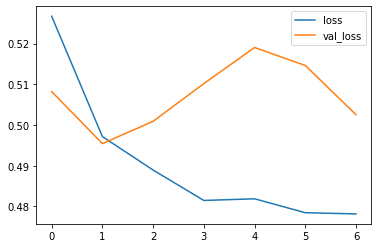

In [11]:
pd.DataFrame(history.history)[['loss', 'val_loss']].iloc[0:].plot()

Nase neuronove site dosahly nejvyssi accuracy 76,6%, tedy o 0,5pp horsi vysledek nez nejlepsi logisticka regrese. Zkusime model neuronovych siti poladit pomoci GridSearch.

# Tuning neuronovych siti

In [12]:
def create_model(optimizer="adam", dropout=0.1, init='uniform', nbr_features=9, dense_nparams=256):
    model = Sequential()
    model.add(Dense(dense_nparams, activation='relu', input_shape=(nbr_features,), kernel_initializer=init,)) 
    model.add(Dropout(dropout), )
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=["accuracy"])
    return model

keras_estimator = KerasClassifier(build_fn=create_model, verbose=1)

param_grid = {
    'epochs': [5],
    'dense_nparams': [32, 256, 512],
    'init': [ 'uniform', 'zeros', 'normal', ], 
    'batch_size':[2, 16, 32],
    # 'kc__optimizer':['RMSprop', 'Adam', 'Adamax', 'sgd'],
    'dropout': [0.4, 0.2, 0]
}

grid = GridSearchCV(estimator=keras_estimator,  
                    n_jobs=-1, 
                    verbose=1,
                    return_train_score=True,
                    cv=5,
                    param_grid=param_grid,)

grid.fit(x_train, y_train)

In [22]:
grid.best_params_

{'batch_size': 32,
 'dense_nparams': 32,
 'dropout': 0.2,
 'epochs': 5,
 'init': 'normal'}

In [23]:
grid.best_score_

0.7752341151237487

In [25]:
acc(y_test, grid.best_estimator_.predict(x_test))

0.7615291262135923

In [ ]:
nn1 = grid.best_estimator_

<hr>

In [47]:
def create_model(optimizer="adam", dropout=0.1, init='uniform', nbr_features=9, dense_nparams=256):
    model = Sequential()
    model.add(Dense(dense_nparams, activation='relu', input_shape=(nbr_features,), kernel_initializer=init,)) 
    model.add(Dropout(dropout), )

    model.add(Dense(dense_nparams, activation='relu')) 
    model.add(Dropout(dropout), )
    
    model.add(Dense(dense_nparams, activation='relu')) 
    model.add(Dropout(dropout), )

    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=["accuracy"])
    return model

keras_estimator = KerasClassifier(build_fn=create_model, verbose=1)

param_grid = {
    'epochs': [5],
    'dense_nparams': [32, 256, 512],
    'init': ['normal'], 
    'batch_size':[32],
    'dropout': [0.4, 0.2, 0]
}

grid = GridSearchCV(estimator=keras_estimator,  
                    n_jobs=-1, 
                    verbose=1,
                    return_train_score=True,
                    cv=5,
                    param_grid=param_grid,)

grid.fit(x_train, y_train)



Fitting 5 folds for each of 9 candidates, totalling 45 fits
Epoch 1/5
206/206 [==============================] - 2s 3ms/step - loss: 0.5895 - accuracy: 0.6933
Epoch 2/5
206/206 [==============================] - 1s 4ms/step - loss: 0.5064 - accuracy: 0.7581
Epoch 3/5
206/206 [==============================] - 1s 3ms/step - loss: 0.4979 - accuracy: 0.7642
Epoch 4/5
206/206 [==============================] - 1s 3ms/step - loss: 0.4919 - accuracy: 0.7683
Epoch 5/5
206/206 [==============================] - 0s 2ms/step - loss: 0.4898 - accuracy: 0.7640


GridSearchCV(cv=5,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x00000214F2CE3A00>,
             n_jobs=-1,
             param_grid={'batch_size': [32], 'dense_nparams': [32, 256, 512],
                         'dropout': [0.4, 0.2, 0], 'epochs': [5],
                         'init': ['normal']},
             return_train_score=True, verbose=1)

In [48]:
grid.best_params_

{'batch_size': 32,
 'dense_nparams': 32,
 'dropout': 0.2,
 'epochs': 5,
 'init': 'normal'}

In [49]:
grid.best_score_

0.7687083721160889

In [52]:
acc(y_test, grid.best_estimator_.predict(x_test))

0.7651669223300971


In [51]:
nn2 = grid.best_estimator_

<hr>

In [40]:
keras_estimator = KerasClassifier(build_fn=create_model, verbose=1)

param_grid = {
    'epochs': [5],
    'dense_nparams': [16, 32, 64],
    'init': ['normal'], 
    'batch_size':[32, 64],
    'dropout': [0.2]
}
grid = GridSearchCV(estimator=keras_estimator,  
                    n_jobs=-1, 
                    verbose=1,
                    return_train_score=True,
                    cv=5,
                    param_grid=param_grid,)
grid.fit(x_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Epoch 1/5
206/206 [==============================] - 1s 1ms/step - loss: 0.6107 - accuracy: 0.6931
Epoch 2/5
206/206 [==============================] - 0s 1ms/step - loss: 0.5103 - accuracy: 0.7587
Epoch 3/5
206/206 [==============================] - 0s 1ms/step - loss: 0.5033 - accuracy: 0.7619
Epoch 4/5
206/206 [==============================] - 0s 1ms/step - loss: 0.4948 - accuracy: 0.7683
Epoch 5/5
206/206 [==============================] - 0s 1ms/step - loss: 0.4950 - accuracy: 0.7693


GridSearchCV(cv=5,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x00000214F1A32880>,
             n_jobs=-1,
             param_grid={'batch_size': [32, 64], 'dense_nparams': [16, 32, 64],
                         'dropout': [0.2], 'epochs': [5], 'init': ['normal']},
             return_train_score=True, verbose=1)

In [41]:
grid.best_params_

{'batch_size': 32,
 'dense_nparams': 16,
 'dropout': 0.2,
 'epochs': 5,
 'init': 'normal'}

In [42]:
acc(y_test, grid.best_estimator_.predict(x_test))

0.7639563106796117

In [ ]:
nn3 = grid.best_estimator_

<hr>

# Shrnuti

Model logisticke regrese po tuningu dosahl presnosti 75,48 % na testovacim setu. Nejlepsi model neuronovych siti dosahl 76,52 %, tedy o 1,04pp lepsi vysledek. Otazka je, zda tento rozdil stoji za vypocetni vykon a cas potrebny k natrenovani site. Dle meho nazoru nestoji.

Popis nejlepsiho modelu:

{'batch_size': 32,
 'dense_nparams': 32,
 'dropout': 0.2,
 'epochs': 5,
 'init': 'normal'}

Sekvencni model Keras se tremi huste propojenymi vrstvami o 32 parametrech, velikosti davky 32 a naslednym 20% dropoutem.